# CNN (key concepts)
Actions we can take to overfit a model:
* Increase the number of convolutional layers
* Increase the number of convolutional filters
* Add another dense layer to the output of our falttened layer

Reduce overfitting (reducing overfitting is also known as regularization):
* Add data augmentation
 * Usually only performed on the training data
 * Images are left as they are in the directories but are modified as they are loaded into the model
* Add regularization layers (such as MaxPool2D)
* Add more data

Actions to take that could improve a model:
* More data
* Data augmentation
* Better data
* Use transfer learning
* Increase the number of model layers (add more Conv2D/MaxPool2D layers)
* Increase the number of filters in each convolutional layer (from 10 to 32 or more)
* Train for longer (more epochs)
* Find and ideal learning rate

Conv2D layer:
* filters - 10, 32, 64, 128 (higher values lead to more complex models)
* kenel_size - 3, 5, 7 (lower values learn smaller features, higher values learn larger features)
* padding - same (output shape is same as input shape) or valid (output shape compressed)
* strides - 1 (default). If images are not informationally dense, strides may be higher, if they are informationally dense, then better to keep lower values of strides

# Process to follow to attack a problem
Steps:
* Create a base model
* Beat the base model by overfitting a larger model
* Reduce overfitting

# Install libraries

In [ ]:
# install keras tuner
!pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 2.0 MB/s 


# Import libraries

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import time
print('tensorflow version = ', tf.__version__)
print('keras version = ', tf.keras.__version__)

tensorflow version =  2.6.0
keras version =  2.6.0


# Constants

In [ ]:
DATASET_NAME = 'rock_paper_scissors'

# set seed for reproducibility
SEED = 33
import os
# set PYTHONHASHSEED environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(SEED)
# set python built-in pseudo-random generator at a fixed value
import random
random.seed(SEED)
# set numpy pseudo-random generator at a fixed value
np.random.seed(SEED)
# set tensorflow pseudo-random generator at a fixed value
tf.random.set_seed(SEED)

BATCH_SIZE = 32
EPOCHS = 25
IMG_SIZE = 100
IMG_DEPTH = 3
TENSORBOARD_LOGDIR = '/content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/'
SAVEDMODELS_DIR = '/content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/'

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Working with the TensorFlow dataset
https://www.tensorflow.org/datasets/catalog/rock_paper_scissors

## Load data

In [ ]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'bair_robot_pushing_small', 'bccd', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19sum', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'dementiabank', 'diabetic_retinopathy_detection', 'div2k', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'emnist', 'eraser_multi_r

In [ ]:
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    name=DATASET_NAME,
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

# access relevant metadata with DatasetInfo
print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteKOR487/rock_paper_scissors-train.tfrecord


  0%|          | 0/2520 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteKOR487/rock_paper_scissors-test.tfrecord


  0%|          | 0/372 [00:00<?, ? examples/s]

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



In [ ]:
NUM_CLASSES = ds_info.features['label'].num_classes
print('NUM_CLASSES = ', NUM_CLASSES)

NAMES_CLASSES = ds_info.features['label'].names
print('NAMES_CLASSES = ', NAMES_CLASSES)

for item in NAMES_CLASSES:
  print(item, ' = ', ds_info.features['label'].str2int(item))

NUM_TRAIN_EXAMPLES = len(ds_train_raw)
print('NUM_TRAIN_EXAMPLES = ', NUM_TRAIN_EXAMPLES)
ds_filtered = list(ds_train_raw.filter(lambda image, label: label == 0).as_numpy_iterator())
print('NUM_TRAIN_EXAMPLES_rock = ', len(ds_filtered))
ds_filtered = list(ds_train_raw.filter(lambda image, label: label == 1).as_numpy_iterator())
print('NUM_TRAIN_EXAMPLES_paper = ', len(ds_filtered))
ds_filtered = list(ds_train_raw.filter(lambda image, label: label == 2).as_numpy_iterator())
print('NUM_TRAIN_EXAMPLES_scissors = ', len(ds_filtered))

NUM_TEST_EXAMPLES = len(ds_test_raw)
print('NUM_TEST_EXAMPLES = ', NUM_TEST_EXAMPLES)
ds_filtered = list(ds_test_raw.filter(lambda image, label: label == 0).as_numpy_iterator())
print('NUM_TEST_EXAMPLES_rock = ', len(ds_filtered))
ds_filtered = list(ds_test_raw.filter(lambda image, label: label == 1).as_numpy_iterator())
print('NUM_TEST_EXAMPLES_paper = ', len(ds_filtered))
ds_filtered = list(ds_test_raw.filter(lambda image, label: label == 2).as_numpy_iterator())
print('NUM_TEST_EXAMPLES_scissors = ', len(ds_filtered))

STEPS_PER_EPOCH = NUM_TRAIN_EXAMPLES//BATCH_SIZE
print('STEPS_PER_EPOCH = ', STEPS_PER_EPOCH)

NUM_CLASSES =  3
NAMES_CLASSES =  ['rock', 'paper', 'scissors']
rock  =  0
paper  =  1
scissors  =  2
NUM_TRAIN_EXAMPLES =  2520
NUM_TRAIN_EXAMPLES_rock =  840
NUM_TRAIN_EXAMPLES_paper =  840
NUM_TRAIN_EXAMPLES_scissors =  840
NUM_TEST_EXAMPLES =  372
NUM_TEST_EXAMPLES_rock =  124
NUM_TEST_EXAMPLES_paper =  124
NUM_TEST_EXAMPLES_scissors =  124
STEPS_PER_EPOCH =  78


The train, test and validation splits are balanced.

In [ ]:
assert isinstance(ds_train_raw, tf.data.Dataset)
print(type(ds_train_raw))
assert isinstance(ds_test_raw, tf.data.Dataset)
print(type(ds_test_raw))

<class 'tensorflow.python.data.ops.dataset_ops._OptionsDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._OptionsDataset'>


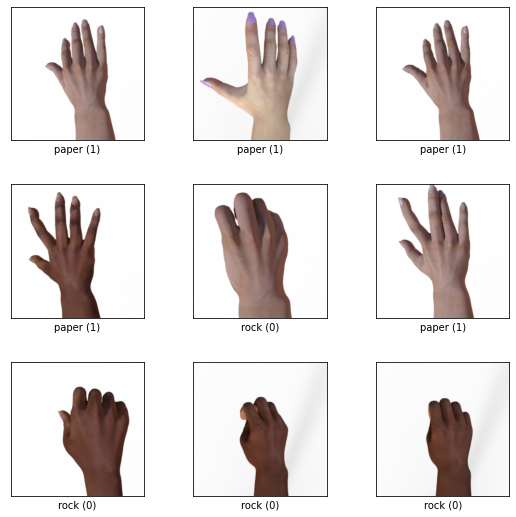

In [ ]:
fig = tfds.show_examples(ds_train_raw, ds_info)

In [ ]:
print('----- ds_train_raw -----')
for i, example in enumerate(ds_train_raw.take(2)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))
print('----- ds_test_raw -----')
for i, example in enumerate(ds_test_raw.take(2)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

----- ds_train_raw -----
Image 1 shape: (300, 300, 3) label: 2
Image 2 shape: (300, 300, 3) label: 2
----- ds_test_raw -----
Image 1 shape: (300, 300, 3) label: 1
Image 2 shape: (300, 300, 3) label: 2


In [ ]:
for image, label in ds_train_raw.take(1):
  print(image)

tf.Tensor(
[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]], shape=(300, 300, 3), dtype=uint8)


## Preprocess data

In [ ]:
def image_preprocess(image, label):
    # convert to tf.float32
    image = tf.cast(image, tf.float32)
    # normalize
    image = (image/255.0)
    # resize image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # one hot encoding label
    label = tf.cast(tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES), dtype=label.dtype)
    return image, label

ds_train = ds_train_raw.map(image_preprocess)
ds_test = ds_test_raw.map(image_preprocess)

In [ ]:
print('----- ds_train -----')
for i, example in enumerate(ds_train.take(2)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))
print('----- ds_test -----')
for i, example in enumerate(ds_test.take(2)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

----- ds_train -----
Image 1 shape: (100, 100, 3) label: [0 0 1]
Image 2 shape: (100, 100, 3) label: [0 0 1]
----- ds_test -----
Image 1 shape: (100, 100, 3) label: [0 1 0]
Image 2 shape: (100, 100, 3) label: [0 0 1]


In [ ]:
for image, label in ds_train.take(1):
  print(image)

tf.Tensor(
[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [0.99607843 0.99607843 0.99607843]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]]

 [[1.         1.         1.        ]
  [1.         1.         1

## Data batching

In [ ]:
ds_train_batched = ds_train.batch(batch_size=BATCH_SIZE)
ds_test_batched = ds_test.batch(batch_size=BATCH_SIZE)

## Data Augmentation layers

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical", seed=SEED),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=1, seed=SEED),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2, seed=SEED)
])

## Helper functions

In [ ]:
# helper functions to plot the validation and training loss and accuracy curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  # plot loss
  ax1.plot(epochs, loss, label='tra_loss')
  ax1.plot(epochs, val_loss, label='val_loss')
  ax1.set_ylim(0, 1)
  ax1.set_title('Loss')
  ax1.set(xlabel='Epochs', ylabel='Loss')
  ax1.legend()

  # plot accuracy
  ax2.plot(epochs, accuracy, label='tra_acc')
  ax2.plot(epochs, val_accuracy, label='val_acc')
  ax2.set_ylim(0, 1)
  ax2.set_title('Accuracy')
  ax2.set(xlabel='Accuracy', ylabel='Loss')
  ax2.legend()

In [ ]:
# helper functions to plot the validation and training loss and accuracy curves separately (for two models)
def plot_loss_curves_compare(history_model1, history_model2):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss_mode1 = history_model1.history['loss']
  val_loss_mode1 = history_model1.history['val_loss']
  accuracy_mode1 = history_model1.history['accuracy']
  val_accuracy_mode1 = history_model1.history['val_accuracy']
  epochs_mode1 = range(len(history_model1.history['loss']))

  loss_mode2 = history_model2.history['loss']
  val_loss_mode2 = history_model2.history['val_loss']
  accuracy_mode2 = history_model2.history['accuracy']
  val_accuracy_mode2 = history_model2.history['val_accuracy']
  epochs_mode2 = range(len(history_model2.history['loss']))

  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 6))

  # plot loss
  ax1.plot(epochs_mode1, loss_mode1, label='tra_loss')
  ax1.plot(epochs_mode1, val_loss_mode1, label='val_loss')
  ax1.set_ylim(0, 1.1)
  ax1.set_title('Loss (current model)')
  ax1.set_facecolor('#D5F5E3')
  ax1.set(xlabel='Epochs', ylabel='Loss')
  ax1.legend()

  # plot loss
  ax2.plot(epochs_mode2, loss_mode2, label='tra_loss')
  ax2.plot(epochs_mode2, val_loss_mode2, label='val_loss')
  ax2.set_ylim(0, 1.1)
  ax2.set_title('Loss (previous model)')
  ax2.set_facecolor('#FDEBD0')
  ax2.set(xlabel='Epochs', ylabel='Loss')
  ax2.legend()

  # plot accuracy
  ax3.plot(epochs_mode1, accuracy_mode1, label='tra_acc')
  ax3.plot(epochs_mode1, val_accuracy_mode1, label='val_acc')
  ax3.set_ylim(0, 1)
  ax3.set_title('Accuracy (current model)')
  ax3.set_facecolor('#D5F5E3')
  ax3.set(xlabel='Epochs', ylabel='Accuracy')
  ax3.legend()

  # plot accuracy
  ax4.plot(epochs_mode2, accuracy_mode2, label='tra_acc')
  ax4.plot(epochs_mode2, val_accuracy_mode2, label='val_acc')
  ax4.set_ylim(0, 1)
  ax4.set_title('Accuracy (previous model)')
  ax4.set_facecolor('#FDEBD0')
  ax4.set(xlabel='Epochs', ylabel='Accuracy')
  ax4.legend()

## Iteration model_00_00 (base model)
Base model:
* Trained for 25 epochs 
* With EarlyStopping callback

### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_00_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_00_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_00_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_00_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_00_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_00_00 = model_00_00.fit(
      ds_train_batched.repeat(),
      epochs=EPOCHS,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/25
78/78 [==============================] - 41s 118ms/step - loss: 0.7728 - accuracy: 0.7436 - val_loss: 0.9602 - val_accuracy: 0.6847
Epoch 2/25
78/78 [==============================] - 9s 112ms/step - loss: 0.0208 - accuracy: 0.9960 - val_loss: 1.4647 - val_accuracy: 0.6875
Epoch 3/25
78/78 [==============================] - 9s 113ms/step - loss: 0.0038 - accuracy: 0.9996 - val_loss: 2.1298 - val_accuracy: 0.6648
Epoch 4/25
78/78 [==============================] - 8s 110ms/step - loss: 9.1594e-04 - accuracy: 1.0000 - val_loss: 1.9074 - val_accuracy: 0.6449
Epoch 5/25
78/78 [==============================] - 8s 108ms/step - loss: 2.9014e-04 - accuracy: 1.0000 - val_loss: 2.2379 - val_accuracy: 0.6506
Epoch 6/25
78/78 [==============================] - 9s 110ms/step - loss: 1.4178e-04 - accuracy: 1.0000 - val_loss: 2.4500 - val_accuracy: 0.6420


In [ ]:
if TRAIN_MODEL:
  # save the model
  model_00_00.save(SAVEDMODELS_DIR + 'model_00_00')
else:
  # load the model
  model_00_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_00_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_00_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_00_00/assets


### Results

In [ ]:
model_00_00.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 10)        280       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 10)        910       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 94, 94, 10)        910       
_________________________________________________________________
flatten_1 (Flatten)          (None, 88360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 265083    
Total params: 267,183
Trainable params: 267,183
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:01:24.25


In [ ]:
# evaluate train data
model_00_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 88ms/step - loss: 1.0594e-04 - accuracy: 1.0000


[0.0001059438509400934, 1.0]

In [ ]:
# evaluate test data
model_00_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 94ms/step - loss: 2.4177 - accuracy: 0.6478


[2.4176764488220215, 0.647849440574646]

### Accuracy & Loss graphs

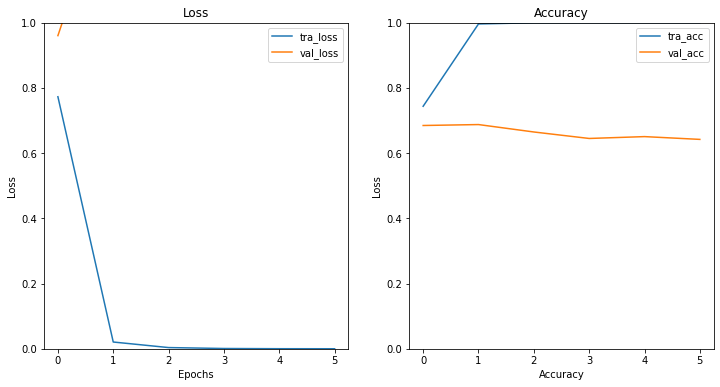

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_00_00)

## Iteration model_01_00 (base model + Data Augmentation)
Same as base model (model_00_00):
* Trained for 25 epochs
* With EarlyStopping callback
* With Data Augmentation 

### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_01_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_01_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_01_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_01_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_01_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_01_00 = model_01_00.fit(
      ds_train_batched.repeat(),
      epochs=EPOCHS,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/25
78/78 [==============================] - 11s 116ms/step - loss: 1.3976 - accuracy: 0.3962 - val_loss: 0.9416 - val_accuracy: 0.5312
Epoch 2/25
78/78 [==============================] - 9s 115ms/step - loss: 0.8897 - accuracy: 0.5740 - val_loss: 0.7925 - val_accuracy: 0.6790
Epoch 3/25
78/78 [==============================] - 8s 109ms/step - loss: 0.7044 - accuracy: 0.6977 - val_loss: 0.6782 - val_accuracy: 0.6903
Epoch 4/25
78/78 [==============================] - 9s 114ms/step - loss: 0.6913 - accuracy: 0.6990 - val_loss: 0.6939 - val_accuracy: 0.6278
Epoch 5/25
78/78 [==============================] - 9s 112ms/step - loss: 0.5817 - accuracy: 0.7588 - val_loss: 0.5902 - val_accuracy: 0.7188
Epoch 6/25
78/78 [==============================] - 8s 108ms/step - loss: 0.5122 - accuracy: 0.7838 - val_loss: 0.4806 - val_accuracy: 0.7983
Epoch 7/25
78/78 [==============================] - 9s 111ms/step - loss: 0.5175 - accuracy: 0.7830 - val_loss: 0.5221 - val_accuracy: 0.7727
Epoch

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_01_00.save(SAVEDMODELS_DIR + 'model_01_00')
else:
  # load the model
  model_01_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_01_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_01_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_01_00/assets


### Results

In [ ]:
model_01_00.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 98, 98, 10)        280       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 10)        910       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 94, 94, 10)        910       
_________________________________________________________________
flatten_2 (Flatten)          (None, 88360)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 265083    
Total params: 267,183
Trainable params: 267,183
Non-trainable params: 0
________________________________________________

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:01:54.71


In [ ]:
# evaluate current model with train data
model_01_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 87ms/step - loss: 0.3764 - accuracy: 0.8575


[0.37639546394348145, 0.8575396537780762]

In [ ]:
# evaluate current model with test data
model_01_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 83ms/step - loss: 0.8111 - accuracy: 0.6694


[0.8110695481300354, 0.6693548560142517]

### Accuracy & Loss graphs

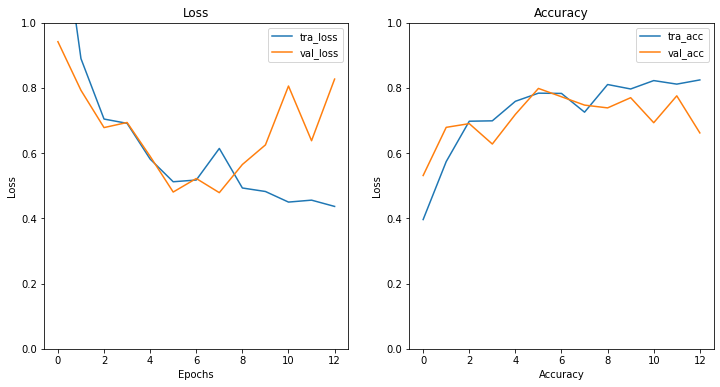

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_01_00) 

## Iteration model_02_00 (base model + extra Dense)
Same as base model (model_00_00):
* Trained for 25 epochs
* With EarlyStopping callback
* With Data Augmentation
* With an extra Dense layer after the Flatten layer
* Using Keras Tuner to discover the optimal number of units of this extra Dense layer

### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_02_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_02_00/

### Define the model

In [ ]:
def model_builder(hp):
  # tune the number of units in the penultimate Dense layer
  # choose an optimal value from 32, 64, 128, 256 or 512
  hp_units = hp.Choice('units', values=[32, 64, 128, 256, 512])

  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(hp_units, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])

  # compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

  return model

### Instantiate the tuner and perform hypertuning

In [ ]:
if TRAIN_MODEL:
  tuner = kt.Hyperband(model_builder,
                       objective='val_accuracy',
                       max_epochs=10,
                       seed=SEED,
                       overwrite=True)

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  ]

In [ ]:
if TRAIN_MODEL:
  tuner.search(
      ds_train_batched.repeat(), 
      epochs=EPOCHS,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(), 
      callbacks=callbacks)

  # get the optimal hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 00m 22s]
val_accuracy: 0.7386363744735718

Best val_accuracy So Far: 0.7386363744735718
Total elapsed time: 00h 02m 37s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
if TRAIN_MODEL:
  print(f"""
  The hyperparameter search is complete. The optimal number of units for the penultimate Dense layer is {best_hps.get('units')}.
  """)


  The hyperparameter search is complete. The optimal number of units for the penultimate Dense layer is 32.
  


### Train the model
Re-instantiate the hypermodel and train it with the optimal number of units for the penultimate Dense layer

In [ ]:
if TRAIN_MODEL:
  # build the model with the optimal hyperparameters and train it
  model_02_00 = tuner.hypermodel.build(best_hps)

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_02_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_02_00 = model_02_00.fit(
      ds_train_batched.repeat(),
      epochs=EPOCHS,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/25
78/78 [==============================] - 11s 121ms/step - loss: 1.1811 - accuracy: 0.4423 - val_loss: 0.9574 - val_accuracy: 0.5455
Epoch 2/25
78/78 [==============================] - 9s 114ms/step - loss: 0.7821 - accuracy: 0.6592 - val_loss: 0.6641 - val_accuracy: 0.7415
Epoch 3/25
78/78 [==============================] - 9s 112ms/step - loss: 0.5819 - accuracy: 0.7568 - val_loss: 0.5257 - val_accuracy: 0.7528
Epoch 4/25
78/78 [==============================] - 8s 107ms/step - loss: 0.5202 - accuracy: 0.7842 - val_loss: 0.4411 - val_accuracy: 0.8352
Epoch 5/25
78/78 [==============================] - 8s 106ms/step - loss: 0.4237 - accuracy: 0.8316 - val_loss: 0.3826 - val_accuracy: 0.8239
Epoch 6/25
78/78 [==============================] - 8s 108ms/step - loss: 0.3677 - accuracy: 0.8637 - val_loss: 0.3784 - val_accuracy: 0.8011
Epoch 7/25
78/78 [==============================] - 9s 112ms/step - loss: 0.3617 - accuracy: 0.8541 - val_loss: 0.4467 - val_accuracy: 0.7841
Epoch

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_02_00.save(SAVEDMODELS_DIR + 'model_02_00')
else:
  # load the model
  model_02_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_02_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_02_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_02_00/assets


### Results

In [ ]:
model_02_00.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 10)        280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 10)        910       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 10)        910       
_________________________________________________________________
flatten (Flatten)            (None, 88360)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                2827552   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:02:31.92


In [ ]:
# evaluate train data
model_02_00.evaluate(ds_train_batched)

79/79 [==============================] - 8s 104ms/step - loss: 0.1322 - accuracy: 0.9583


[0.1322033852338791, 0.9583333134651184]

In [ ]:
# evaluate test data
model_02_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 85ms/step - loss: 0.2567 - accuracy: 0.9005


[0.2567249536514282, 0.9005376100540161]

### Accuracy & Loss graphs

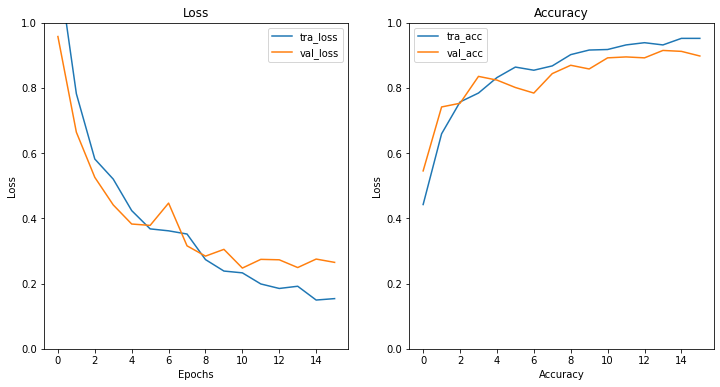

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_02_00)

## Iteration model_03_00 (base model + MaxPool2D)
Same as base model (model_00_00):
* Trained for 25 epochs
* With EarlyStopping callback
* With Data Augmentation
* With MaxPool2D layers (regularization layers)

### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_03_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_03_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_03_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_03_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_03_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_03_00 = model_03_00.fit(
      ds_train_batched.repeat(),
      epochs=EPOCHS,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/25
78/78 [==============================] - 11s 117ms/step - loss: 1.0754 - accuracy: 0.4079 - val_loss: 0.9836 - val_accuracy: 0.5511
Epoch 2/25
78/78 [==============================] - 9s 110ms/step - loss: 0.9373 - accuracy: 0.5434 - val_loss: 0.7695 - val_accuracy: 0.7102
Epoch 3/25
78/78 [==============================] - 9s 112ms/step - loss: 0.8087 - accuracy: 0.6334 - val_loss: 0.7126 - val_accuracy: 0.6932
Epoch 4/25
78/78 [==============================] - 8s 110ms/step - loss: 0.6767 - accuracy: 0.7114 - val_loss: 0.5861 - val_accuracy: 0.8239
Epoch 5/25
78/78 [==============================] - 8s 107ms/step - loss: 0.5895 - accuracy: 0.7592 - val_loss: 0.5449 - val_accuracy: 0.7415
Epoch 6/25
78/78 [==============================] - 8s 108ms/step - loss: 0.4969 - accuracy: 0.8047 - val_loss: 0.6117 - val_accuracy: 0.6903
Epoch 7/25
78/78 [==============================] - 8s 108ms/step - loss: 0.4109 - accuracy: 0.8356 - val_loss: 0.5115 - val_accuracy: 0.7528
Epoch

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_03_00.save(SAVEDMODELS_DIR + 'model_03_00')
else:
  # load the model
  model_03_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_03_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_03_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_03_00/assets


### Results

In [ ]:
model_03_00.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 10)        910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:02:17.77


In [ ]:
# evaluate current model with train data
model_03_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 90ms/step - loss: 0.1598 - accuracy: 0.9444


[0.15976764261722565, 0.9444444179534912]

In [ ]:
# evaluate current model with test data
model_03_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 89ms/step - loss: 0.5154 - accuracy: 0.7715


[0.5154210925102234, 0.7715053558349609]

### Accuracy & Loss graphs

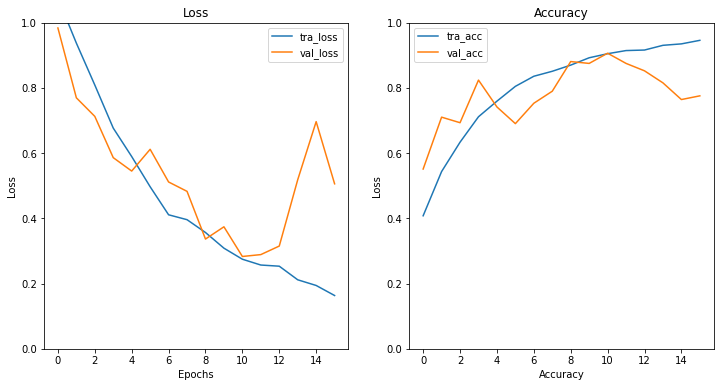

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_03_00)

## Iteration model_04_00 (base model + Dropout)
Same as base model (model_00_00):
* Trained for 25 epochs
* With EarlyStopping callback
* With Data Augmentation
* With Dropout layers (regularization layers)
* Using Keras Tuner to discover the optimal rate of the Dropout layers

### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_04_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_04_00/

### Define the model

In [ ]:
def model_builder(hp):
  # tune the rate of Dropout layers
  # choose an optimal value from 0.1, 0.2, or 0.3
  hp_rate = hp.Choice('rate', values=[0.1, 0.2, 0.3])

  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.Dropout(rate=hp_rate, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.Dropout(rate=hp_rate, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.Dropout(rate=hp_rate, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])

  # compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

  return model

### Instantiate the tuner and perform hypertuning

In [ ]:
if TRAIN_MODEL:
  tuner = kt.Hyperband(model_builder,
                       objective='val_accuracy',
                       max_epochs=10,
                       seed=SEED,
                       overwrite=True)

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  ]

In [ ]:
if TRAIN_MODEL:
  tuner.search(
      ds_train_batched.repeat(), 
      epochs=EPOCHS,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(), 
      callbacks=callbacks)
  
  # get the optimal hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 3 Complete [00h 00m 22s]
val_accuracy: 0.3863636255264282

Best val_accuracy So Far: 0.49715909361839294
Total elapsed time: 00h 01m 06s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
if TRAIN_MODEL:
  print(f"""
  The hyperparameter search is complete. The optimal rate of the Dropout layers is {best_hps.get('rate')}.
  """)


  The hyperparameter search is complete. The optimal rate of the Dropout layers is 0.3.
  


### Train the model
Re-instantiate the hypermodel and train it with the optimal rate for the Dropout layers

In [ ]:
if TRAIN_MODEL:
  # build the model with the optimal hyperparameters and train it
  model_04_00 = tuner.hypermodel.build(best_hps)

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_04_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_04_00 = model_04_00.fit(
      ds_train_batched.repeat(),
      epochs=EPOCHS,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/25
78/78 [==============================] - 11s 123ms/step - loss: 1.3814 - accuracy: 0.3442 - val_loss: 1.0986 - val_accuracy: 0.3352
Epoch 2/25
78/78 [==============================] - 9s 116ms/step - loss: 1.0946 - accuracy: 0.3593 - val_loss: 1.0986 - val_accuracy: 0.3352
Epoch 3/25
78/78 [==============================] - 9s 113ms/step - loss: 1.0908 - accuracy: 0.3682 - val_loss: 1.0985 - val_accuracy: 0.3352
Epoch 4/25
78/78 [==============================] - 9s 113ms/step - loss: 1.0834 - accuracy: 0.3931 - val_loss: 1.0877 - val_accuracy: 0.3693
Epoch 5/25
78/78 [==============================] - 9s 117ms/step - loss: 1.0359 - accuracy: 0.4550 - val_loss: 0.9670 - val_accuracy: 0.5398
Epoch 6/25
78/78 [==============================] - 9s 113ms/step - loss: 0.9491 - accuracy: 0.5289 - val_loss: 0.7937 - val_accuracy: 0.7273
Epoch 7/25
78/78 [==============================] - 9s 112ms/step - loss: 0.8509 - accuracy: 0.5916 - val_loss: 0.7111 - val_accuracy: 0.7159
Epoch

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_04_00.save(SAVEDMODELS_DIR + 'model_04_00')
else:
  # load the model
  model_04_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_04_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_04_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_04_00/assets


### Results

In [ ]:
model_04_00.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 10)        280       
_________________________________________________________________
dropout (Dropout)            (None, 98, 98, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 10)        910       
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 10)        910       
_________________________________________________________________
dropout_2 (Dropout)          (None, 94, 94, 10)        0

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:03:00.65


In [ ]:
# evaluate train data
model_04_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 89ms/step - loss: 0.2248 - accuracy: 0.9254


[0.22482459247112274, 0.9253968000411987]

In [ ]:
# evaluate test data
model_04_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 85ms/step - loss: 0.7316 - accuracy: 0.7151


[0.7315853238105774, 0.7150537371635437]

### Accuracy & Loss graphs

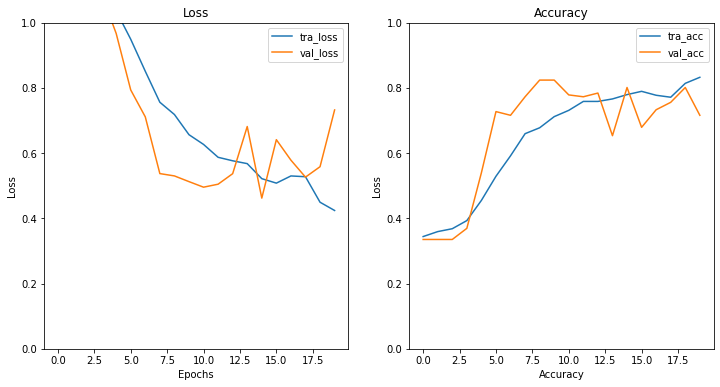

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_04_00)

## Iteration model_05_00 (base model + extra Dense + MaxPool2D + Dropout)
Same as base model (model_00_00):
* Trained for 25 epochs
* With Earlystopping callback
* With Data Augmentation
* With an extra Dense layer after the Flatten layer
* With MaxPool2D layers (regularization layers)
* With Dropout layers (regularization layers)

### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_05_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_05_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_05_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_05_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_05_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_05_00 = model_05_00.fit(
      ds_train_batched.repeat(),
      epochs=EPOCHS,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/25
78/78 [==============================] - 10s 112ms/step - loss: 1.1232 - accuracy: 0.3710 - val_loss: 1.0945 - val_accuracy: 0.3636
Epoch 2/25
78/78 [==============================] - 9s 115ms/step - loss: 1.0143 - accuracy: 0.4944 - val_loss: 1.0706 - val_accuracy: 0.3750
Epoch 3/25
78/78 [==============================] - 8s 109ms/step - loss: 0.8455 - accuracy: 0.6069 - val_loss: 0.9784 - val_accuracy: 0.5028
Epoch 4/25
78/78 [==============================] - 8s 108ms/step - loss: 0.6385 - accuracy: 0.7195 - val_loss: 0.6956 - val_accuracy: 0.6818
Epoch 5/25
78/78 [==============================] - 8s 108ms/step - loss: 0.5000 - accuracy: 0.7930 - val_loss: 0.6207 - val_accuracy: 0.6989
Epoch 6/25
78/78 [==============================] - 9s 110ms/step - loss: 0.4169 - accuracy: 0.8348 - val_loss: 0.5008 - val_accuracy: 0.7614
Epoch 7/25
78/78 [==============================] - 9s 111ms/step - loss: 0.3186 - accuracy: 0.8714 - val_loss: 0.4461 - val_accuracy: 0.7898
Epoch

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_05_00.save(SAVEDMODELS_DIR + 'model_05_00')
else:
  # load the model
  model_05_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_05_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_05_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_05_00/assets


### Results

In [ ]:
model_05_00.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 23, 23, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:03:35.06


In [ ]:
# evaluate current model with train data
model_05_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 87ms/step - loss: 0.0369 - accuracy: 0.9829


[0.03692803904414177, 0.9829365015029907]

In [ ]:
# evaluate current model with test data
model_05_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 83ms/step - loss: 0.0523 - accuracy: 0.9919


[0.052265096455812454, 0.9919354915618896]

### Accuracy & Loss graphs

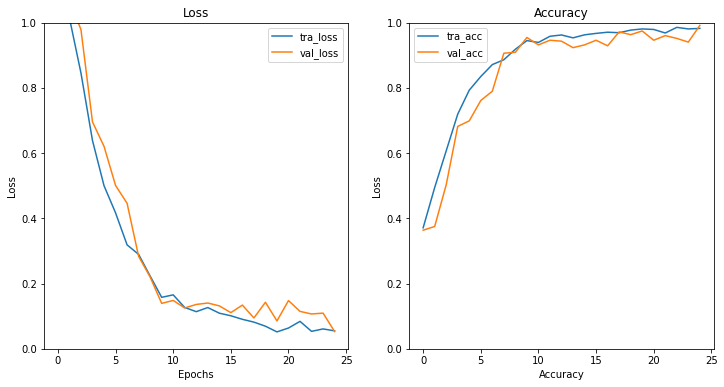

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_05_00)

## Iteration model_06_00 - Exponential decay (with exponential decay, k = 0.1 and initial_learning_rate = 1e-3)
Same as model_05_00:
* Trained for 100 epochs
* Without Earlystopping callback
* With Data Augmentation
* With LearningRateScheduler callback (with exponential decay, k = 0.1 and initial_learning_rate = 1e-3)



### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_06_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_06_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_06_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_06_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

Exponential decay  
learning_rate = initial_learning_rate * e ^ (-k * epoch)

In [ ]:
if TRAIN_MODEL:
  # this function decreases the initial learning rate exponentially
  initial_learning_rate = 1e-3
  def scheduler(epoch, lr):
    k = 0.1
    return initial_learning_rate * tf.math.exp(-k * epoch)

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.LearningRateScheduler(scheduler),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_06_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_06_00 = model_06_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 10s 112ms/step - loss: 1.1212 - accuracy: 0.4010 - val_loss: 1.0207 - val_accuracy: 0.4659
Epoch 2/100
78/78 [==============================] - 8s 108ms/step - loss: 0.9387 - accuracy: 0.5394 - val_loss: 0.8464 - val_accuracy: 0.6875
Epoch 3/100
78/78 [==============================] - 8s 106ms/step - loss: 0.7792 - accuracy: 0.6435 - val_loss: 0.6723 - val_accuracy: 0.7301
Epoch 4/100
78/78 [==============================] - 9s 112ms/step - loss: 0.6561 - accuracy: 0.7094 - val_loss: 0.5547 - val_accuracy: 0.7926
Epoch 5/100
78/78 [==============================] - 9s 113ms/step - loss: 0.5450 - accuracy: 0.7701 - val_loss: 0.4567 - val_accuracy: 0.8693
Epoch 6/100
78/78 [==============================] - 9s 112ms/step - loss: 0.4707 - accuracy: 0.8111 - val_loss: 0.4195 - val_accuracy: 0.8665
Epoch 7/100
78/78 [==============================] - 8s 108ms/step - loss: 0.3784 - accuracy: 0.8545 - val_loss: 0.3939 - val_accuracy: 0.883

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_06_00.save(SAVEDMODELS_DIR + 'model_06_00')
else:
  model_06_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_06_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_06_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_06_00/assets


### Results

In [ ]:
model_06_00.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:14:19.30


In [ ]:
# evaluate current model with train data
model_06_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 88ms/step - loss: 0.1190 - accuracy: 0.9671


[0.11899147927761078, 0.9670634865760803]

In [ ]:
# evaluate current model with test data
model_06_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 86ms/step - loss: 0.3284 - accuracy: 0.8683


[0.3284277617931366, 0.8682795763015747]

### Accuracy & Loss graphs

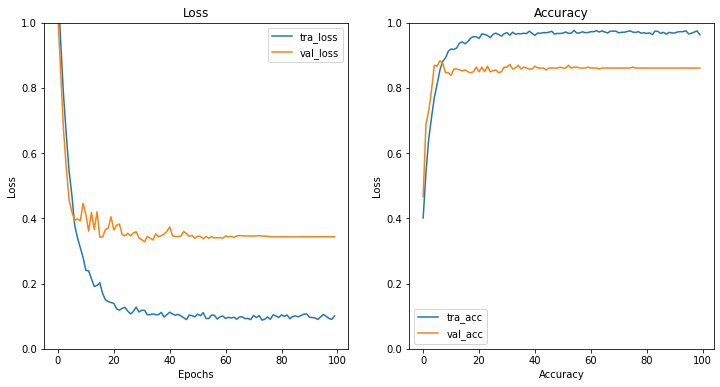

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_06_00)

## Iteration model_07_00 - Exponential decay (with exponential decay, k = 0.01 and initial_learning_rate = 1e-3)
Same as model_05_00:
* Trained for 100 epochs
* Without Earlystopping callback
* With Data Augmentation
* With LearningRateScheduler callback (with exponential decay, k = 0.01 and initial_learning_rate = 1e-3)



### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_07_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_07_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_07_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_07_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

Exponential decay  
learning_rate = initial_learning_rate * e ^ (-k * epoch)

In [ ]:
if TRAIN_MODEL:
  # this function decreases the initial learning rate exponentially
  initial_learning_rate = 1e-3
  def scheduler(epoch, lr):
    k = 0.01
    return initial_learning_rate * tf.math.exp(-k * epoch)

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.LearningRateScheduler(scheduler),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_07_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_07_00 = model_07_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 11s 118ms/step - loss: 1.0726 - accuracy: 0.4135 - val_loss: 0.9834 - val_accuracy: 0.5057
Epoch 2/100
78/78 [==============================] - 8s 107ms/step - loss: 0.8534 - accuracy: 0.6121 - val_loss: 0.7521 - val_accuracy: 0.7727
Epoch 3/100
78/78 [==============================] - 9s 112ms/step - loss: 0.6738 - accuracy: 0.6941 - val_loss: 0.4946 - val_accuracy: 0.8438
Epoch 4/100
78/78 [==============================] - 8s 108ms/step - loss: 0.5121 - accuracy: 0.7846 - val_loss: 0.4481 - val_accuracy: 0.7983
Epoch 5/100
78/78 [==============================] - 9s 111ms/step - loss: 0.3966 - accuracy: 0.8424 - val_loss: 0.2513 - val_accuracy: 0.9403
Epoch 6/100
78/78 [==============================] - 8s 106ms/step - loss: 0.3522 - accuracy: 0.8545 - val_loss: 0.3944 - val_accuracy: 0.8210
Epoch 7/100
78/78 [==============================] - 8s 110ms/step - loss: 0.2529 - accuracy: 0.9043 - val_loss: 0.5181 - val_accuracy: 0.752

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_07_00.save(SAVEDMODELS_DIR + 'model_07_00')
else:
  model_07_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_07_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_07_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_07_00/assets


### Results

In [ ]:
model_07_00.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 23, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:15:24.04


In [ ]:
# evaluate current model with train data
model_07_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 89ms/step - loss: 0.0082 - accuracy: 0.9984


[0.008180761709809303, 0.9984126687049866]

In [ ]:
# evaluate current model with test data
model_07_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 86ms/step - loss: 0.1630 - accuracy: 0.9462


[0.16295748949050903, 0.9462365508079529]

### Accuracy & Loss graphs

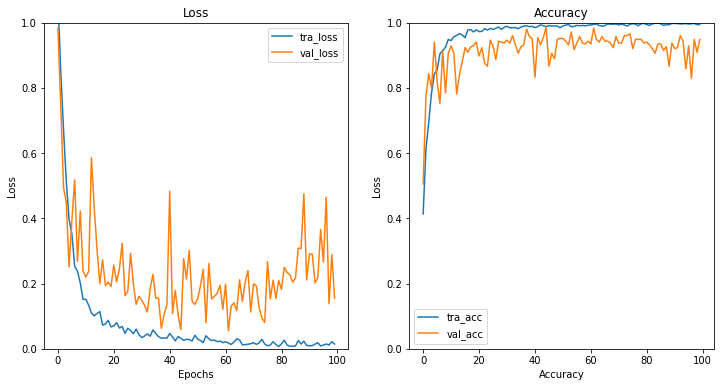

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_07_00)

## Iteration model_08_00 - Exponential decay (with exponential decay, k = 0.001 and initial_learning_rate = 1e-3)
Same as model_05_00:
* Trained for 100 epochs
* Without Earlystopping callback
* With Data Augmentation
* With LearningRateScheduler callback (with exponential decay, k = 0.001 and initial_learning_rate = 1e-3)



### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_08_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_08_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_08_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_08_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

Exponential decay  
learning_rate = initial_learning_rate * e ^ (-k * epoch)

In [ ]:
if TRAIN_MODEL:
  # this function decreases the initial learning rate exponentially
  initial_learning_rate = 1e-3
  def scheduler(epoch, lr):
    k = 0.001
    return initial_learning_rate * tf.math.exp(-k * epoch)

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.LearningRateScheduler(scheduler),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_08_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_08_00 = model_08_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 11s 119ms/step - loss: 1.0599 - accuracy: 0.4179 - val_loss: 1.0770 - val_accuracy: 0.4375
Epoch 2/100
78/78 [==============================] - 9s 113ms/step - loss: 0.9003 - accuracy: 0.5571 - val_loss: 0.9628 - val_accuracy: 0.4943
Epoch 3/100
78/78 [==============================] - 8s 110ms/step - loss: 0.7445 - accuracy: 0.6588 - val_loss: 0.7617 - val_accuracy: 0.7330
Epoch 4/100
78/78 [==============================] - 9s 113ms/step - loss: 0.5491 - accuracy: 0.7681 - val_loss: 0.5562 - val_accuracy: 0.7585
Epoch 5/100
78/78 [==============================] - 9s 113ms/step - loss: 0.4298 - accuracy: 0.8207 - val_loss: 0.6475 - val_accuracy: 0.6847
Epoch 6/100
78/78 [==============================] - 9s 111ms/step - loss: 0.3383 - accuracy: 0.8597 - val_loss: 0.5731 - val_accuracy: 0.7699
Epoch 7/100
78/78 [==============================] - 9s 111ms/step - loss: 0.2976 - accuracy: 0.8842 - val_loss: 0.2869 - val_accuracy: 0.889

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_08_00.save(SAVEDMODELS_DIR + 'model_08_00')
else:
  model_08_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_08_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_08_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_08_00/assets


### Results

In [ ]:
model_08_00.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 23, 23, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:15:23.74


In [ ]:
# evaluate current model with train data
model_08_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 90ms/step - loss: 0.0208 - accuracy: 0.9909


[0.020756863057613373, 0.9908730387687683]

In [ ]:
# evaluate current model with test data
model_08_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 85ms/step - loss: 0.0278 - accuracy: 0.9892


[0.027811717242002487, 0.9892473220825195]

### Accuracy & Loss graphs

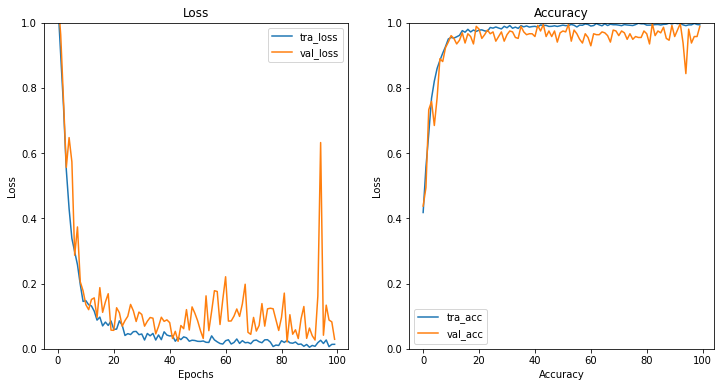

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_08_00)

## Iteration model_09_00 - Step decay
Same as model_05_00:
* Trained for 100 epochs
* Without Earlystopping callback
* With Data Augmentation
* With LearningRateScheduler callback (with step decay, drop_rate = 0.5, epochs_drop = 10 and initial_learning_rate = 1e-3)



### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_09_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_09_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_09_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_09_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

Step decay  
learning_rate = initial_lr * drop_rate ^ floor(epoch / epochs_drop)

In [ ]:
if TRAIN_MODEL:
  # this function decreases the initial learning rate at specific times during training
  def scheduler(epoch, lr):
    initial_learning_rate = 1e-3
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * tf.math.pow(drop_rate, tf.math.floor(epoch / epochs_drop))

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.LearningRateScheduler(scheduler),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_09_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_09_00 = model_09_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 11s 120ms/step - loss: 1.1288 - accuracy: 0.4058 - val_loss: 1.0933 - val_accuracy: 0.3466
Epoch 2/100
78/78 [==============================] - 9s 113ms/step - loss: 1.0055 - accuracy: 0.4771 - val_loss: 1.0576 - val_accuracy: 0.4375
Epoch 3/100
78/78 [==============================] - 9s 114ms/step - loss: 0.8625 - accuracy: 0.5804 - val_loss: 0.9756 - val_accuracy: 0.4403
Epoch 4/100
78/78 [==============================] - 10s 125ms/step - loss: 0.6870 - accuracy: 0.6873 - val_loss: 0.8216 - val_accuracy: 0.5710
Epoch 5/100
78/78 [==============================] - 9s 116ms/step - loss: 0.5767 - accuracy: 0.7416 - val_loss: 0.7525 - val_accuracy: 0.6705
Epoch 6/100
78/78 [==============================] - 9s 111ms/step - loss: 0.4815 - accuracy: 0.7974 - val_loss: 0.7324 - val_accuracy: 0.6534
Epoch 7/100
78/78 [==============================] - 9s 111ms/step - loss: 0.3993 - accuracy: 0.8324 - val_loss: 0.8667 - val_accuracy: 0.63

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_09_00.save(SAVEDMODELS_DIR + 'model_09_00')
else:
  model_09_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_09_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_09_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_09_00/assets


### Results

In [ ]:
model_09_00.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 23, 23, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:14:40.20


In [ ]:
# evaluate current model with train data
model_09_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 87ms/step - loss: 0.0254 - accuracy: 0.9909


[0.02536829188466072, 0.9908730387687683]

In [ ]:
# evaluate current model with test data
model_09_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 86ms/step - loss: 0.4416 - accuracy: 0.8817


[0.4416016638278961, 0.8817204236984253]

### Accuracy & Loss graphs

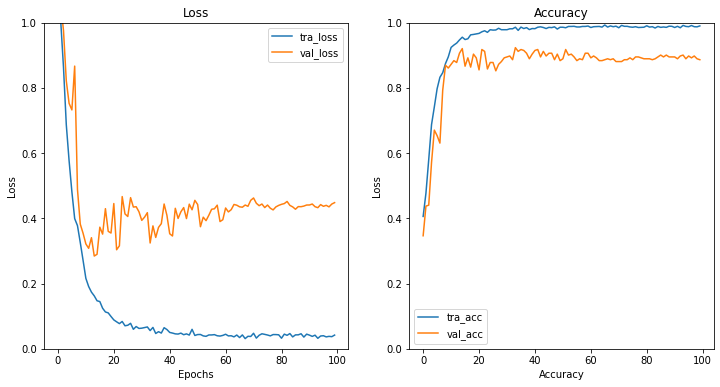

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_09_00)

## Iteration model_10_00 - Time-based decay
Same as model_05_00:
* Trained for 100 epochs
* Without Earlystopping callback
* With Data Augmentation
* With LearningRateScheduler callback (with time-based decay, initial_learning_rate = 1e-3 and num_of_epochs = 100)



### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_10_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_10_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_10_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_10_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

Time-based decay  
learning_rate = lr * 1 / (1 + decay * epoch)  
decay = initial_learning_rate / num_of_epoches 

In [ ]:
if TRAIN_MODEL:
  def scheduler(epoch, lr):
    initial_learning_rate = 1e-3
    epochs = 100
    decay = initial_learning_rate / epochs
    return lr * 1 / (1 + decay * epoch)

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.LearningRateScheduler(scheduler),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_10_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_10_00 = model_10_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 10s 113ms/step - loss: 1.0541 - accuracy: 0.4339 - val_loss: 1.0609 - val_accuracy: 0.4460
Epoch 2/100
78/78 [==============================] - 9s 111ms/step - loss: 0.8353 - accuracy: 0.6033 - val_loss: 0.9606 - val_accuracy: 0.4631
Epoch 3/100
78/78 [==============================] - 9s 112ms/step - loss: 0.6452 - accuracy: 0.7203 - val_loss: 0.7627 - val_accuracy: 0.6392
Epoch 4/100
78/78 [==============================] - 9s 112ms/step - loss: 0.4918 - accuracy: 0.7970 - val_loss: 0.6712 - val_accuracy: 0.6790
Epoch 5/100
78/78 [==============================] - 8s 107ms/step - loss: 0.3768 - accuracy: 0.8489 - val_loss: 0.6514 - val_accuracy: 0.7386
Epoch 6/100
78/78 [==============================] - 8s 110ms/step - loss: 0.2937 - accuracy: 0.8838 - val_loss: 0.5908 - val_accuracy: 0.7670
Epoch 7/100
78/78 [==============================] - 9s 110ms/step - loss: 0.2459 - accuracy: 0.9128 - val_loss: 0.4414 - val_accuracy: 0.838

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_10_00.save(SAVEDMODELS_DIR + 'model_10_00')
else:
  model_10_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_10_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_10_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_10_00/assets


### Results

In [ ]:
model_10_00.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 23, 23, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:15:23.67


In [ ]:
# evaluate current model with train data
model_10_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 90ms/step - loss: 3.6771e-04 - accuracy: 1.0000


[0.00036770597216673195, 1.0]

In [ ]:
# evaluate current model with test data
model_10_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 86ms/step - loss: 0.3141 - accuracy: 0.9005


[0.31406912207603455, 0.9005376100540161]

### Accuracy & Loss graphs

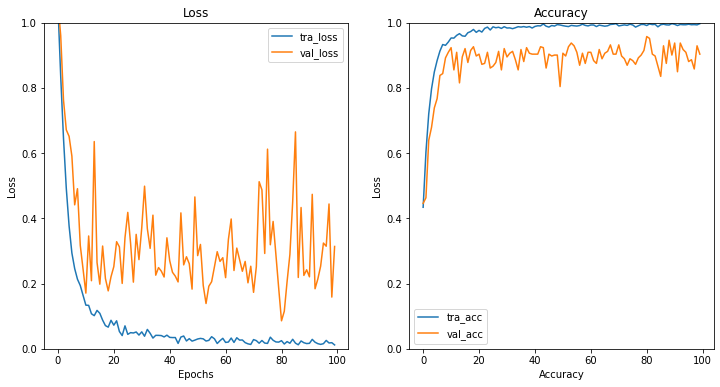

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_10_00)

## Iteration model_11_00 - Constant learning rate = 1e-3
Same as model_05_00:
* Trained for 100 epochs
* Without Earlystopping callback
* With Data Augmentation
* Constant learning rate = 1e-3



### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_11_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_11_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_11_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_11_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      metrics=['accuracy'])

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_11_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_11_00 = model_11_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 11s 117ms/step - loss: 1.2067 - accuracy: 0.3574 - val_loss: 1.0902 - val_accuracy: 0.4432
Epoch 2/100
78/78 [==============================] - 9s 114ms/step - loss: 1.0079 - accuracy: 0.4819 - val_loss: 1.0656 - val_accuracy: 0.4148
Epoch 3/100
78/78 [==============================] - 8s 110ms/step - loss: 0.8623 - accuracy: 0.5928 - val_loss: 0.9677 - val_accuracy: 0.5341
Epoch 4/100
78/78 [==============================] - 9s 112ms/step - loss: 0.7218 - accuracy: 0.6700 - val_loss: 0.8407 - val_accuracy: 0.6932
Epoch 5/100
78/78 [==============================] - 9s 113ms/step - loss: 0.5750 - accuracy: 0.7621 - val_loss: 0.5391 - val_accuracy: 0.7727
Epoch 6/100
78/78 [==============================] - 8s 109ms/step - loss: 0.4484 - accuracy: 0.8143 - val_loss: 0.4086 - val_accuracy: 0.8040
Epoch 7/100
78/78 [==============================] - 8s 108ms/step - loss: 0.3791 - accuracy: 0.8473 - val_loss: 0.3735 - val_accuracy: 0.804

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_11_00.save(SAVEDMODELS_DIR + 'model_11_00')
else:
  model_11_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_11_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_11_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_11_00/assets


### Results

In [ ]:
model_11_00.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 23, 23, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:14:43.71


In [ ]:
# evaluate current model with train data
model_11_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 92ms/step - loss: 2.3160e-04 - accuracy: 1.0000


[0.0002315952442586422, 1.0]

In [ ]:
# evaluate current model with test data
model_11_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 88ms/step - loss: 0.2721 - accuracy: 0.9301


[0.2720828652381897, 0.9301075339317322]

### Accuracy & Loss graphs

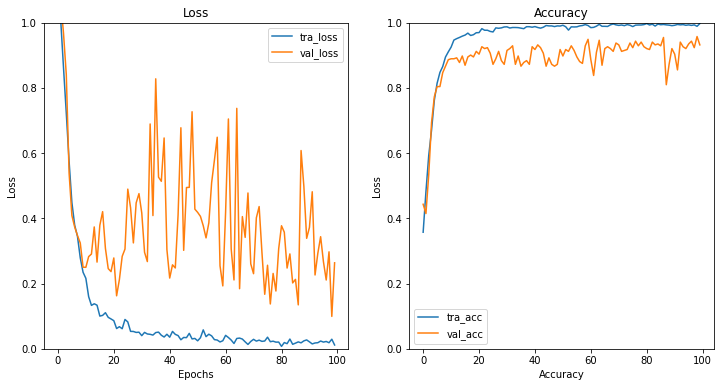

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_11_00)

## Iteration model_12_00 - Constant learning rate = 1e-4
Same as model_05_00:
* Trained for 100 epochs
* Without Earlystopping callback
* With Data Augmentation
* Constant learning rate = 1e-4



### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_12_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_12_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_12_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_12_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      metrics=['accuracy'])

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_12_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_12_00 = model_12_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 11s 121ms/step - loss: 1.0922 - accuracy: 0.3814 - val_loss: 1.0829 - val_accuracy: 0.4119
Epoch 2/100
78/78 [==============================] - 9s 123ms/step - loss: 1.0686 - accuracy: 0.4353 - val_loss: 1.0705 - val_accuracy: 0.4716
Epoch 3/100
78/78 [==============================] - 9s 112ms/step - loss: 1.0332 - accuracy: 0.4819 - val_loss: 1.0475 - val_accuracy: 0.4602
Epoch 4/100
78/78 [==============================] - 9s 115ms/step - loss: 0.9909 - accuracy: 0.5370 - val_loss: 1.0142 - val_accuracy: 0.4915
Epoch 5/100
78/78 [==============================] - 9s 115ms/step - loss: 0.9255 - accuracy: 0.5667 - val_loss: 0.9718 - val_accuracy: 0.5085
Epoch 6/100
78/78 [==============================] - 9s 111ms/step - loss: 0.8823 - accuracy: 0.5924 - val_loss: 0.9378 - val_accuracy: 0.5114
Epoch 7/100
78/78 [==============================] - 9s 112ms/step - loss: 0.8419 - accuracy: 0.6266 - val_loss: 0.8960 - val_accuracy: 0.565

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_12_00.save(SAVEDMODELS_DIR + 'model_12_00')
else:
  model_12_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_12_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_12_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_12_00/assets


### Results

In [ ]:
model_12_00.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 23, 23, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:15:23.76


In [ ]:
# evaluate current model with train data
model_12_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 89ms/step - loss: 0.2991 - accuracy: 0.9036


[0.299148291349411, 0.9035714268684387]

In [ ]:
# evaluate current model with test data
model_12_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 86ms/step - loss: 0.2064 - accuracy: 0.9220


[0.2064247727394104, 0.9220430254936218]

### Accuracy & Loss graphs

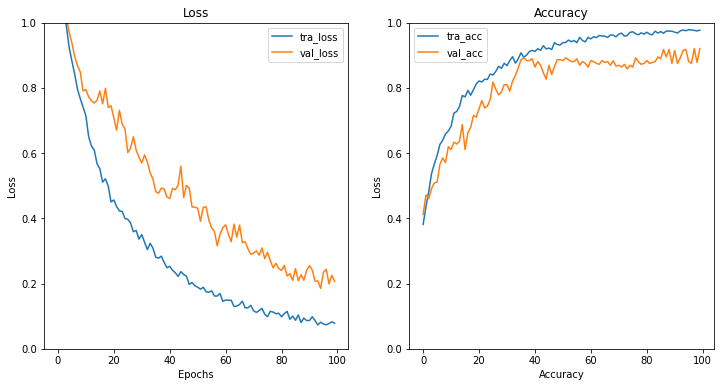

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_12_00)

## Iteration model_13_00 - Constant learning rate = 1e-5
Same as model_05_00:
* Trained for 100 epochs
* Without Earlystopping callback
* With Data Augmentation
* Constant learning rate = 1e-5



### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_13_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_13_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_13_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_13_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
      metrics=['accuracy'])

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_13_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_13_00 = model_13_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 11s 116ms/step - loss: 1.1152 - accuracy: 0.3001 - val_loss: 1.1016 - val_accuracy: 0.3295
Epoch 2/100
78/78 [==============================] - 9s 112ms/step - loss: 1.1054 - accuracy: 0.3404 - val_loss: 1.0999 - val_accuracy: 0.3267
Epoch 3/100
78/78 [==============================] - 9s 115ms/step - loss: 1.1029 - accuracy: 0.3396 - val_loss: 1.0987 - val_accuracy: 0.3324
Epoch 4/100
78/78 [==============================] - 9s 112ms/step - loss: 1.0982 - accuracy: 0.3605 - val_loss: 1.0973 - val_accuracy: 0.3352
Epoch 5/100
78/78 [==============================] - 9s 111ms/step - loss: 1.0910 - accuracy: 0.3714 - val_loss: 1.0965 - val_accuracy: 0.3352
Epoch 6/100
78/78 [==============================] - 8s 110ms/step - loss: 1.0954 - accuracy: 0.3650 - val_loss: 1.0957 - val_accuracy: 0.3352
Epoch 7/100
78/78 [==============================] - 8s 108ms/step - loss: 1.0898 - accuracy: 0.3710 - val_loss: 1.0946 - val_accuracy: 0.340

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_13_00.save(SAVEDMODELS_DIR + 'model_13_00')
else:
  model_13_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_13_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_13_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_13_00/assets


### Results

In [ ]:
model_13_00.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 23, 23, 10)       

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:14:23.75


In [ ]:
# evaluate current model with train data
model_13_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 85ms/step - loss: 1.0441 - accuracy: 0.4817


[1.0440622568130493, 0.48174601793289185]

In [ ]:
# evaluate current model with test data
model_13_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 81ms/step - loss: 1.0986 - accuracy: 0.4919


[1.0986318588256836, 0.49193549156188965]

### Accuracy & Loss graphs

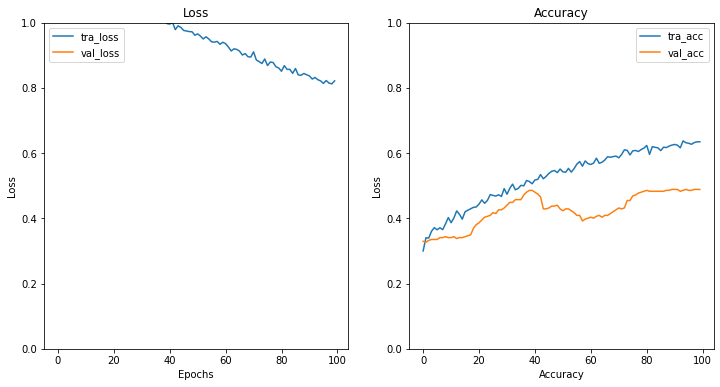

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_13_00)

## Iteration model_14_00 - Constant learning rate = 1e-4 (trained for longer)
Same as model_12_00:
* Trained for 200 epochs
* Without Earlystopping callback
* With Data Augmentation
* Constant learning rate = 1e-4



### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_14_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_14_00/

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_14_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_14_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      metrics=['accuracy'])

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_14_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_14_00 = model_14_00.fit(
      ds_train_batched.repeat(),
      epochs=200,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/200
78/78 [==============================] - 11s 116ms/step - loss: 1.1114 - accuracy: 0.3458 - val_loss: 1.0953 - val_accuracy: 0.3466
Epoch 2/200
78/78 [==============================] - 8s 109ms/step - loss: 1.0850 - accuracy: 0.3754 - val_loss: 1.0889 - val_accuracy: 0.3949
Epoch 3/200
78/78 [==============================] - 9s 122ms/step - loss: 1.0674 - accuracy: 0.4216 - val_loss: 1.0735 - val_accuracy: 0.4631
Epoch 4/200
78/78 [==============================] - 9s 111ms/step - loss: 1.0294 - accuracy: 0.4727 - val_loss: 1.0540 - val_accuracy: 0.4489
Epoch 5/200
78/78 [==============================] - 9s 112ms/step - loss: 0.9804 - accuracy: 0.5265 - val_loss: 1.0307 - val_accuracy: 0.4659
Epoch 6/200
78/78 [==============================] - 9s 110ms/step - loss: 0.9394 - accuracy: 0.5490 - val_loss: 1.0195 - val_accuracy: 0.5114
Epoch 7/200
78/78 [==============================] - 8s 104ms/step - loss: 0.8938 - accuracy: 0.5808 - val_loss: 1.0013 - val_accuracy: 0.536

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_14_00.save(SAVEDMODELS_DIR + 'model_14_00')
else:
  model_14_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_14_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_14_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_14_00/assets


### Results

In [ ]:
model_14_00.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 98, 98, 10)        280       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 49, 49, 10)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 47, 47, 10)        910       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 23, 23, 10)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 23, 23, 10)      

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:29:18.10


In [ ]:
# evaluate current model with train data
model_14_00.evaluate(ds_train_batched)

79/79 [==============================] - 8s 94ms/step - loss: 0.0089 - accuracy: 0.9976


[0.008887935429811478, 0.9976190328598022]

In [ ]:
# evaluate current model with test data
model_14_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 90ms/step - loss: 0.1594 - accuracy: 0.9328


[0.1594088226556778, 0.9327957034111023]

### Accuracy & Loss graphs

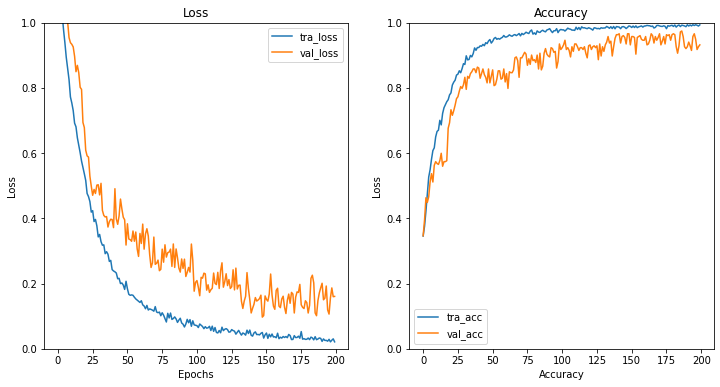

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_14_00)

## Iteration model_15_00 - Feature Extraction (DenseNet121) with Step Decay
* DenseNet121 model unfreezed
* Trained for 100 epochs
* With Earlystopping callback
* With Data Augmentation
* Without LearningRateScheduler callback (with step decay, drop_rate = 0.5, epochs_drop = 5 and initial_learning_rate = 1e-4)

### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_15_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_15_00/

### Preprocess data

In [ ]:
def image_preprocess_densenet(image, label):
    # convert to tf.float32
    image = tf.cast(image, tf.float32)
    # normalize
    image = tf.keras.applications.densenet.preprocess_input(x=image)
    # resize image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # one hot encoding label
    label = tf.cast(tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES), dtype=label.dtype)
    return image, label

ds_train = ds_train_raw.map(image_preprocess_densenet)
ds_test = ds_test_raw.map(image_preprocess_densenet)

In [ ]:
print('----- ds_train -----')
for i, example in enumerate(ds_train.take(2)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))
print('----- ds_test -----')
for i, example in enumerate(ds_test.take(2)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

----- ds_train -----
Image 1 shape: (100, 100, 3) label: [0 0 1]
Image 2 shape: (100, 100, 3) label: [0 0 1]
----- ds_test -----
Image 1 shape: (100, 100, 3) label: [0 1 0]
Image 2 shape: (100, 100, 3) label: [0 0 1]


In [ ]:
for image, label in ds_train.take(1):
  print(image)

tf.Tensor(
[[[2.2489083 2.4285715 2.64     ]
  [2.2146587 2.3935575 2.6051416]
  [2.2146587 2.3935575 2.6051416]
  ...
  [2.1804092 2.3585434 2.5702832]
  [2.1975338 2.3760502 2.5877128]
  [2.1804092 2.3585434 2.5702832]]

 [[2.2489083 2.4285715 2.64     ]
  [2.2146587 2.3935575 2.6051416]
  [2.2317834 2.4110641 2.622571 ]
  ...
  [2.1975338 2.3760502 2.5877128]
  [2.1975338 2.3760502 2.5877128]
  [2.1804092 2.3585434 2.5702832]]

 [[2.2489083 2.4285715 2.64     ]
  [2.2317834 2.4110641 2.622571 ]
  [2.2317834 2.4110641 2.622571 ]
  ...
  [2.1804092 2.3585434 2.5702832]
  [2.1804092 2.3585434 2.5702832]
  [2.1804092 2.3585434 2.5702832]]

 ...

 [[2.1975338 2.3760502 2.5877128]
  [2.1461596 2.3235295 2.535425 ]
  [2.1975338 2.3760502 2.5877128]
  ...
  [2.1461596 2.3235295 2.535425 ]
  [2.129035  2.3060222 2.5179958]
  [2.129035  2.3060222 2.5179958]]

 [[2.1975338 2.3760502 2.5877128]
  [2.1975338 2.3760502 2.5877128]
  [2.1975338 2.3760502 2.5877128]
  ...
  [2.1461596 2.3235295 2.53

### Data batching

In [ ]:
ds_train_batched = ds_train.batch(batch_size=BATCH_SIZE)
ds_test_batched = ds_test.batch(batch_size=BATCH_SIZE)

### Create the pre trained base model

In [ ]:
# create the pre trained model
base_model = tf.keras.applications.DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH),
                                               include_top=False,
                                               weights='imagenet',
                                               classes=NUM_CLASSES)

base_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
_______________________

In [ ]:
base_model.trainable = True

In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       base_model,
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(rate=0.1, seed=SEED),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_15_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_15_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

Step decay  
learning_rate = initial_lr * drop_rate ^ floor(epoch / epochs_drop)

In [ ]:
if TRAIN_MODEL:
  # this function decreases the initial learning rate at specific times during training
  def scheduler(epoch, lr):
    initial_learning_rate = 1e-4
    drop_rate = 0.5
    epochs_drop = 5.0
    return initial_learning_rate * tf.math.pow(drop_rate, tf.math.floor(epoch / epochs_drop))

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5),
      tf.keras.callbacks.LearningRateScheduler(scheduler),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_15_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_15_00 = model_15_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 40s 331ms/step - loss: 0.0776 - accuracy: 0.9752 - val_loss: 0.7077 - val_accuracy: 0.8409
Epoch 2/100
78/78 [==============================] - 22s 289ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.1700 - val_accuracy: 0.9091
Epoch 3/100
78/78 [==============================] - 22s 287ms/step - loss: 6.0221e-04 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9773
Epoch 4/100
78/78 [==============================] - 22s 284ms/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.3730 - val_accuracy: 0.8892
Epoch 5/100
78/78 [==============================] - 21s 268ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/100
78/78 [==============================] - 22s 282ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/100
78/78 [==============================] - 21s 269ms/step - loss: 6.2148e-04 - accuracy: 1.0000 - val_loss: 0.0038 - val_a

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_15_00.save(SAVEDMODELS_DIR + 'model_15_00')
else:
  model_15_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_15_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_15_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_15_00/assets


### Results

In [ ]:
model_15_00.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_______________________________________

In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:04:34.20


In [ ]:
# evaluate current model with train data
model_15_00.evaluate(ds_train_batched)

79/79 [==============================] - 13s 167ms/step - loss: 1.1148e-04 - accuracy: 1.0000


[0.00011147828627144918, 1.0]

In [ ]:
# evaluate current model with test data
model_15_00.evaluate(ds_test_batched)

12/12 [==============================] - 2s 156ms/step - loss: 0.0027 - accuracy: 1.0000


[0.0027030673809349537, 1.0]

### Accuracy & Loss graphs

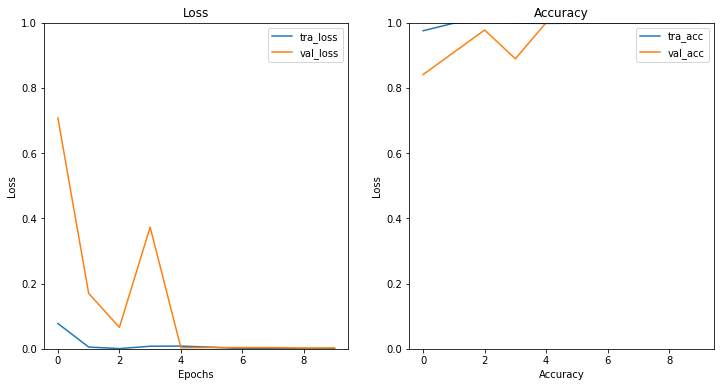

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_15_00)

## Iteration model_16_00 - Feature Extraction (MobileNet) with Step Decay
* MobileNet model unfreezed
* Trained for 100 epochs
* Without Earlystopping callback
* With Data Augmentation
* Without LearningRateScheduler callback (with step decay, drop_rate = 0.5, epochs_drop = 5 and initial_learning_rate = 1e-3)

### ¿Train?

In [ ]:
TRAIN_MODEL = True
if TRAIN_MODEL:
  # clear any logs from previous runs
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/model_16_00/
  # clear saved model
  !rm -rf /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_16_00/

### Preprocess data
MobileNet needs input pixels scaled between -1 and 1

In [ ]:
def image_preprocess_mobilenet(image, label):
    # convert to tf.float32
    image = tf.cast(image, tf.float32)
    # normalize
    image = tf.keras.applications.mobilenet.preprocess_input(x=image)
    # resize image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # one hot encoding label
    label = tf.cast(tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES), dtype=label.dtype)
    return image, label

ds_train = ds_train_raw.map(image_preprocess_mobilenet)
ds_test = ds_test_raw.map(image_preprocess_mobilenet)

In [ ]:
print('----- ds_train -----')
for i, example in enumerate(ds_train.take(2)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))
print('----- ds_test -----')
for i, example in enumerate(ds_test.take(2)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

----- ds_train -----
Image 1 shape: (100, 100, 3) label: [0 1 0]
Image 2 shape: (100, 100, 3) label: [0 1 0]
----- ds_test -----
Image 1 shape: (100, 100, 3) label: [0 0 1]
Image 2 shape: (100, 100, 3) label: [0 0 1]


In [ ]:
for image, label in ds_train.take(1):
  print(image)

tf.Tensor(
[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [0.99215686 0.99215686 0.99215686]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.99215686 0.99215686 0.99215686]
  [0.99215686 0.99215686 0.99215686]
  [0.99215686 0.99215686 0.99215686]]

 [[1.         1.         1.        ]
  [1.         1.         1

### Data batching

In [ ]:
ds_train_batched = ds_train.batch(batch_size=BATCH_SIZE)
ds_test_batched = ds_test.batch(batch_size=BATCH_SIZE)

### Create the pre trained base model

In [ ]:
# create the pre trained model
base_model = tf.keras.applications.MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH),
                                             include_top=False,
                                             weights='imagenet',
                                             classes=NUM_CLASSES)

base_model.summary()

17235968/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32)        128       
_________________________________________________

In [ ]:
base_model.trainable = True

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 50, 50, 32) 

### Function create model

In [ ]:
def make_model():
  model = tf.keras.models.Sequential(
      [data_augmentation,
       base_model,
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')])
  return model

### Train the model

In [ ]:
if TRAIN_MODEL:
  # create the model
  model_16_00 = make_model()

In [ ]:
if TRAIN_MODEL:
  # compile the model
  model_16_00.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

Step decay  
learning_rate = initial_lr * drop_rate ^ floor(epoch / epochs_drop)

In [ ]:
if TRAIN_MODEL:
  # this function decreases the initial learning rate at specific times during training
  def scheduler(epoch, lr):
    initial_learning_rate = 1e-3
    drop_rate = 0.5
    epochs_drop = 5.0
    return initial_learning_rate * tf.math.pow(drop_rate, tf.math.floor(epoch / epochs_drop))

In [ ]:
if TRAIN_MODEL:
  # create callbacks
  callbacks = [
      tf.keras.callbacks.LearningRateScheduler(scheduler),
      tf.keras.callbacks.TensorBoard(
          log_dir=TENSORBOARD_LOGDIR + 'model_16_00', 
          histogram_freq=1)
  ]

In [ ]:
if TRAIN_MODEL:
  # fit the model
  time_start = time.time()
  history_16_00 = model_16_00.fit(
      ds_train_batched.repeat(),
      epochs=100,
      steps_per_epoch=NUM_TRAIN_EXAMPLES // BATCH_SIZE,
      validation_steps=NUM_TEST_EXAMPLES // BATCH_SIZE,
      validation_data=ds_test_batched.repeat(),
      callbacks=callbacks)
  time_end = time.time()

Epoch 1/100
78/78 [==============================] - 16s 139ms/step - loss: 0.7267 - accuracy: 0.8850 - val_loss: 6.0692 - val_accuracy: 0.6761
Epoch 2/100
78/78 [==============================] - 10s 122ms/step - loss: 0.2588 - accuracy: 0.9574 - val_loss: 8.0302 - val_accuracy: 0.7131
Epoch 3/100
78/78 [==============================] - 10s 126ms/step - loss: 0.1110 - accuracy: 0.9799 - val_loss: 1.1529 - val_accuracy: 0.8324
Epoch 4/100
78/78 [==============================] - 9s 122ms/step - loss: 0.1065 - accuracy: 0.9751 - val_loss: 1.2041 - val_accuracy: 0.8125
Epoch 5/100
78/78 [==============================] - 9s 121ms/step - loss: 0.0293 - accuracy: 0.9900 - val_loss: 0.1289 - val_accuracy: 0.9403
Epoch 6/100
78/78 [==============================] - 9s 121ms/step - loss: 0.0118 - accuracy: 0.9956 - val_loss: 0.0791 - val_accuracy: 0.9744
Epoch 7/100
78/78 [==============================] - 10s 124ms/step - loss: 0.0063 - accuracy: 0.9976 - val_loss: 0.5876 - val_accuracy: 0.

In [ ]:
if TRAIN_MODEL:
  # save the model
  model_16_00.save(SAVEDMODELS_DIR + 'model_16_00')
else:
  model_16_00 = tf.keras.models.load_model(SAVEDMODELS_DIR + 'model_16_00')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_16_00/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/SavedModels/model_16_00/assets


### Results

In [ ]:
model_16_00.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 3, 3, 1024)        3228864   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
if TRAIN_MODEL:
  # time elapsed for training
  hour, rem = divmod(time_end - time_start, 3600)
  minute, second = divmod(rem, 60)
  print('time elapsed for training {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

time elapsed for training 00:17:46.93


In [ ]:
# evaluate current model with train data
model_16_00.evaluate(ds_train_batched)

79/79 [==============================] - 7s 93ms/step - loss: 1.8088e-06 - accuracy: 1.0000


[1.8088022670781356e-06, 1.0]

In [ ]:
# evaluate current model with test data
model_16_00.evaluate(ds_test_batched)

12/12 [==============================] - 1s 110ms/step - loss: 0.0841 - accuracy: 0.9677


[0.08414529263973236, 0.9677419066429138]

### Accuracy & Loss graphs

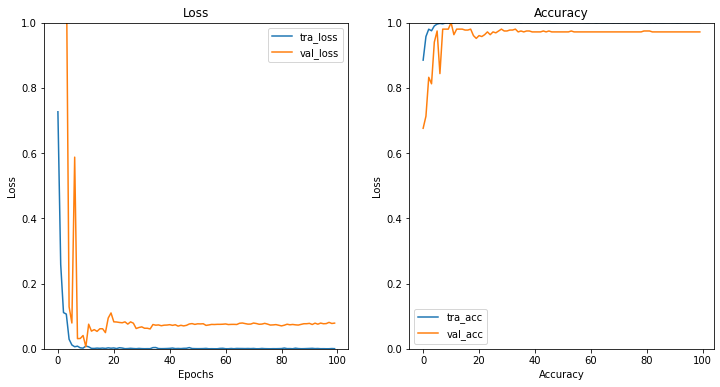

In [ ]:
if TRAIN_MODEL:
  # check out the loss curves of model
  plot_loss_curves(history_16_00)

## TensorBoard

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/TensorFlow/Certifications/TensorFlow Developer Certification/Labs/jupyter notebooks/TensorflowDatasets_ImageClassification_MulticlassClassification_RockPaperScissors/TensorBoard/logdir/'

<IPython.core.display.Javascript object>